# Data analysis and modeling on dataset 1

## Data preparation

First we import all the libraries we plan on using at this point in time:

In [1]:
# import pandas for structuring the data
import pandas as pd
import pandas_profiling
from pandas.plotting import scatter_matrix

# import numpy for numerical analysis
import numpy as np
from scipy import stats

# import libs for diagrams inline with the text
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# other utilities
from sklearn import datasets, preprocessing, metrics, tree
from sklearn.model_selection import train_test_split
import sklearn.ensemble as ske
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Then we load our dataset into the notebook and print out the shape and the first five entries:

In [2]:
df = pd.read_csv('datasets/heart.csv')
print(df.shape)
df.head()

(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


We then run df.describe() to give an overview of the data:

In [3]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


We check if our data contains any null and n/a values we need to be aware of:

In [4]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [5]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

We would like to see the datatypes we have in our dataframe:

In [6]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

From this it looks like we won't have to do any converting of datatypes, since everything is numerical.

Now we want to look at the data to see if we can identify any outliers. To do this we'll make some plots to help us visualize the data. First let's make a histogram of our columns to start with.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'cp'}>,
        <AxesSubplot:title={'center':'trestbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>,
        <AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>],
       [<AxesSubplot:title={'center':'exang'}>,
        <AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'thal'}>,
        <AxesSubplot:title={'center':'target'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

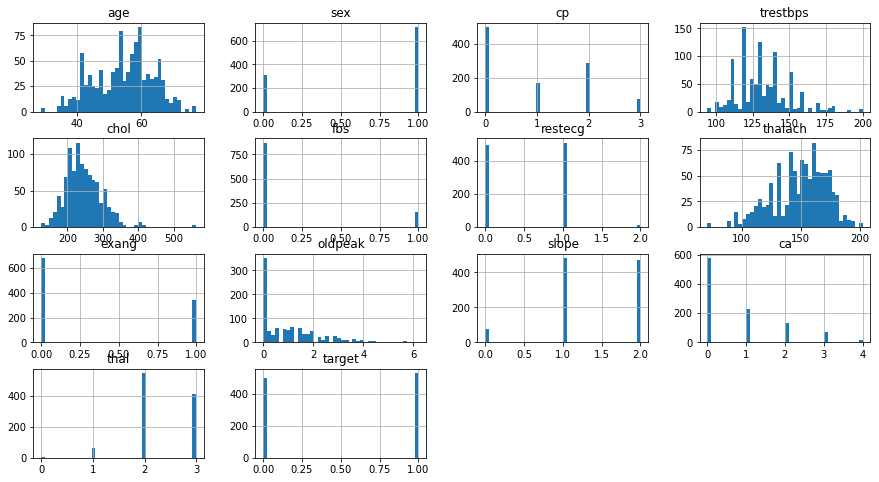

In [7]:
df.hist(bins= 40, figsize=(15, 8))

Now what we see here are the different distributions of our columns, and at first glance it would seem that "age", "trestbps", "chol", "thalach" and "oldpeak" has some outliers. Let's identify these outliers using the Z-score and IQR(Inter Quartile Range).

In [8]:
def iqr_calc(column):
    # IQR
    Q1 = np.percentile(df[column], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(df[column], 75,
                   interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    upperBound = (Q3+1.5*IQR)
    lowerBound = (Q1-1.5*IQR)

    # Above Upper bound
    upper = df[column] >= upperBound
 
    print("Upper bound:",upperBound)
    print(np.where(upper))
 
    # Below Lower bound
    lower = df[column] <= lowerBound
    print("Lower bound:", lowerBound)
    print(np.where(lower))
    
def z_score(column):
    # Z score 
    z = np.abs(stats.zscore(df['thalach']))
    threshold = 3
    # Position of the outlier
    print(np.where(z > 3))

Now we'll use these above functions on our outlier suspects.

In [9]:
# IQR for "age"
iqr_calc("age")

Upper bound: 80.5
(array([], dtype=int64),)
Lower bound: 28.5
(array([], dtype=int64),)


In [10]:
# Z-score for age
z_score("age")

(array([267, 296, 378, 559], dtype=int64),)


<AxesSubplot:xlabel='age'>

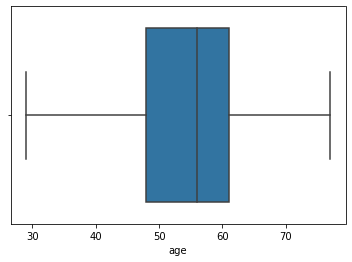

In [11]:
# To visualize the "age" outliers
sns.boxplot(x = df['age'])

The IQR didn't identify any outliers, whilst the z-score did. We won't be removing any entries in "age" for now.

In [12]:
# IQR for "thalach"
iqr_calc("thalach")

Upper bound: 217.0
(array([], dtype=int64),)
Lower bound: 81.0
(array([267, 296, 378, 559], dtype=int64),)


In [13]:
# Z-score for "thalach"
z_score("thalach")

(array([267, 296, 378, 559], dtype=int64),)


<AxesSubplot:xlabel='thalach'>

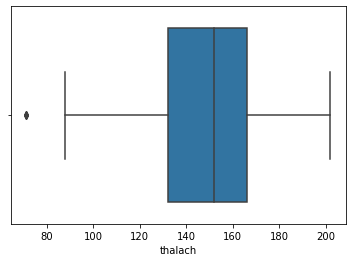

In [14]:
sns.boxplot(x = df['thalach'])

Now for "thalach", IQR and Z-score identified the same four entries. We should probably remove these.

In [15]:
outliers = df[df['thalach'] < 81.0]
df = df.drop(outliers.index.values)

In [16]:
# IQR for "trestbps"
iqr_calc("trestbps")

Upper bound: 170.0
(array([ 29,  47,  65,  70,  87, 135, 137, 151, 165, 175, 203, 229, 235,
       246, 257, 264, 293, 324, 341, 393, 411, 433, 449, 493, 505, 506,
       525, 536, 605, 608, 620, 632, 675, 677, 684, 794, 815, 833, 858,
       868, 887, 892, 940, 967, 982], dtype=int64),)
Lower bound: 90.0
(array([], dtype=int64),)


In [17]:
# Z-score for "trestbps"
z_score("trestbps")

(array([], dtype=int64),)


<AxesSubplot:xlabel='trestbps'>

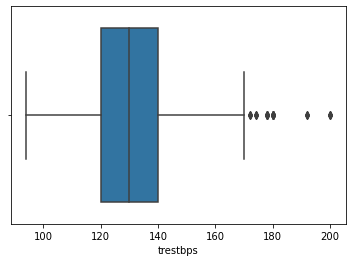

In [18]:
sns.boxplot(x = df['trestbps'])

For "trestbps" the IQR calculater found many entries above the upper bound, whilst the z-score found none. For now we won't be removing any entries since we thing there are too many entries above the upper bound.

In [19]:
# IQR for "chol"
iqr_calc("chol")

Upper bound: 371.0
(array([123, 158, 179, 192, 255, 447, 461, 478, 539, 574, 637, 661, 681,
       885, 954, 992], dtype=int64),)
Lower bound: 115.0
(array([], dtype=int64),)


In [20]:
# Z-score for "chol"
z_score("chol")

(array([], dtype=int64),)


<AxesSubplot:xlabel='chol'>

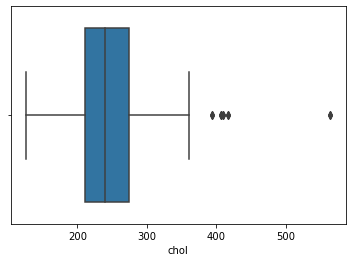

In [21]:
sns.boxplot(x = df['chol'])

For now we won't be removing any entries based on this, since we believe there to be too many to remove.

In [22]:
# IQR for "oldpeak"
iqr_calc("oldpeak")

Upper bound: 4.5
(array([ 54,  55,  69, 390, 523, 609, 829], dtype=int64),)
Lower bound: -2.7
(array([], dtype=int64),)


In [23]:
# Z-score for "oldpeak"
z_score("oldpeak")

(array([], dtype=int64),)


<AxesSubplot:xlabel='oldpeak'>

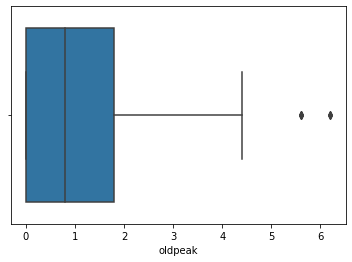

In [24]:
sns.boxplot(x = df['oldpeak'])

Based on these IQR and z-score calculations and also the boxplot, we believe it would benefit us to remove these 7 entries from the data.

In [25]:
outliers = df[df['oldpeak'] > 4.5]
df = df.drop(outliers.index.values)

Below We will generate a pandas_profiling document that contains useful graphs and algoritms used on our data.

In [26]:
#pandas_profiling.ProfileReport(df).to_file("profiling/profiling_data1.html")

From the results in this above profile report, we'll extract the highlights.

First off, we will take a look at the correlation heatmap of our data using the "Pearson's r" to look at any linear correlations between the different parameters:

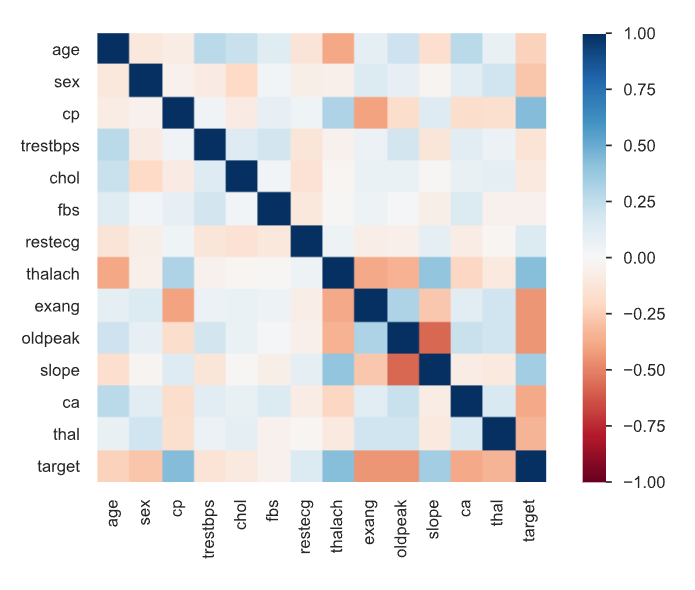

Based on this heatmap, we get an overview image of the different degrees of linear correlations. To quantify these correlations we can get the correlations with pandas:

In [27]:
corr = df.corr(method="pearson")
cmap = sns.cm.vlag_r
corr.style.background_gradient(cmap=cmap)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.104322,-0.065083,0.273323,0.226939,0.125393,-0.136597,-0.383593,0.094388,0.209989,-0.163316,0.274158,0.072835,-0.223274
sex,-0.104322,1.000000,-0.040827,-0.072064,-0.205328,0.027680,-0.064788,-0.038377,0.135662,0.100610,-0.029872,0.126943,0.203744,-0.281769
cp,-0.065083,-0.040827,1.000000,0.042316,-0.089412,0.075548,0.047735,0.297917,-0.405046,-0.159283,0.117876,-0.178011,-0.159800,0.429060
trestbps,0.273323,-0.072064,0.042316,1.000000,0.137469,0.184602,-0.119570,-0.045555,0.060759,0.170105,-0.109708,0.095031,0.051193,-0.136073
chol,0.226939,-0.205328,-0.089412,0.137469,1.000000,0.023857,-0.150846,-0.029685,0.067340,0.100164,-0.030872,0.083428,0.108370,-0.108883
fbs,0.125393,0.027680,0.075548,0.184602,0.023857,1.000000,-0.102921,-0.017969,0.049847,0.023979,-0.070781,0.138831,-0.040112,-0.046137
restecg,-0.136597,-0.064788,0.047735,-0.119570,-0.150846,-0.102921,1.000000,0.067784,-0.070827,-0.054016,0.091627,-0.067498,-0.019477,0.140081
thalach,-0.383593,-0.038377,0.297917,-0.045555,-0.029685,-0.017969,0.067784,1.000000,-0.394402,-0.353147,0.388990,-0.229757,-0.100580,0.416073
exang,0.094388,0.135662,-0.405046,0.060759,0.067340,0.049847,-0.070827,-0.394402,1.000000,0.319161,-0.267810,0.116066,0.194023,-0.442388
oldpeak,0.209989,0.100610,-0.159283,0.170105,0.100164,0.023979,-0.054016,-0.353147,0.319161,1.000000,-0.554699,0.219624,0.183715,-0.438036


Here is a numeric overview of the different correlations. From this we can get a sense of which values have the highest either positive or negative correlation with "target" which is whether or not a person has a heart disease. We would like to take a closer look at the most noticable values.

#### "cp" - Chest pain type 
With a correlation coefficient of 0.435

In [28]:
chestPain = df.groupby('cp').mean()
chestPain

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
cp,,,,,,,,,,,,,
0,55.660494,0.732510,132.078189,250.903292,0.135802,0.475309,140.829218,0.574074,1.378807,1.263374,0.985597,2.450617,0.251029
1,51.245509,0.658683,128.119760,244.700599,0.095808,0.616766,162.179641,0.071856,0.323952,1.658683,0.425150,2.155689,0.802395
2,53.517606,0.616197,130.077465,242.197183,0.193662,0.598592,155.116197,0.130282,0.784507,1.507042,0.619718,2.211268,0.771127
3,56.012987,0.831169,140.961039,237.064935,0.207792,0.402597,157.129870,0.168831,1.380519,1.259740,0.493506,2.259740,0.662338


<AxesSubplot:xlabel='Chest pain type'>

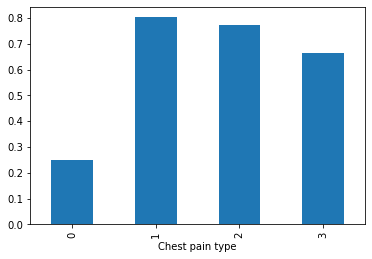

In [29]:
# plot
chestPain['target'].plot.bar(xlabel="Chest pain type")

In this chart we can see a clear distinction between the different types of chest pain and whether or not a person has heart disease. Based on this chart looks like there might be a difference between chest pain type 0 and the rest.

#### exang - Exercise induced angina
With a correlation coefficient of -0.4380

In [30]:
exangina = df.groupby('exang').mean()
exangina

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,oldpeak,slope,ca,thal,target
exang,,,,,,,,,,,,,
0,53.750371,0.650817,1.249629,130.783061,243.918276,0.138187,0.554235,155.890045,0.78633,1.512630,0.668648,2.234770,0.676077
1,55.563050,0.782991,0.366569,133.035191,251.275660,0.175953,0.475073,137.140762,1.53695,1.167155,0.920821,2.489736,0.208211


<AxesSubplot:xlabel='exang'>

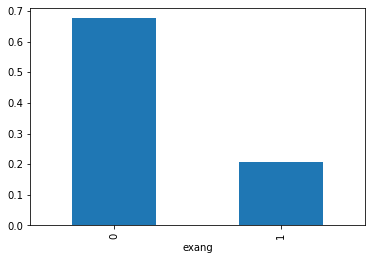

In [31]:
exangina["target"].plot.bar()

Based on this chart there seems to be a strong negative correlation between whether a person gets exercise enduced angina and if they have a heart disease. So it seems to indicate that if a person gets exercise enduces angina, then they have a lower risk of having a heart disease.

#### thalach - Maximum heart rate achieved
With a correlation coefficient of 0.423

In [32]:
maxHR = df.groupby('thalach').mean()
maxHR.head()

,age,sex,cp,trestbps,chol,fbs,restecg,exang,oldpeak,slope,ca,thal,target
thalach,,,,,,,,,,,,,
88,57.000000,1.000000,0.000000,152.0,274.000000,0.000000,1.000000,1.000000,1.200000,1.000000,1.000000,3.0,0.000000
90,59.000000,1.000000,0.000000,164.0,176.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.0,0.000000
95,53.000000,1.000000,0.000000,123.0,282.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,3.0,0.000000
96,62.285714,0.571429,0.857143,120.0,216.857143,0.428571,0.428571,0.571429,1.257143,0.857143,0.571429,2.0,0.428571
97,62.000000,0.000000,2.000000,130.0,263.000000,0.000000,1.000000,0.000000,1.200000,1.000000,1.000000,3.0,0.000000


<AxesSubplot:xlabel='Max heart rate'>

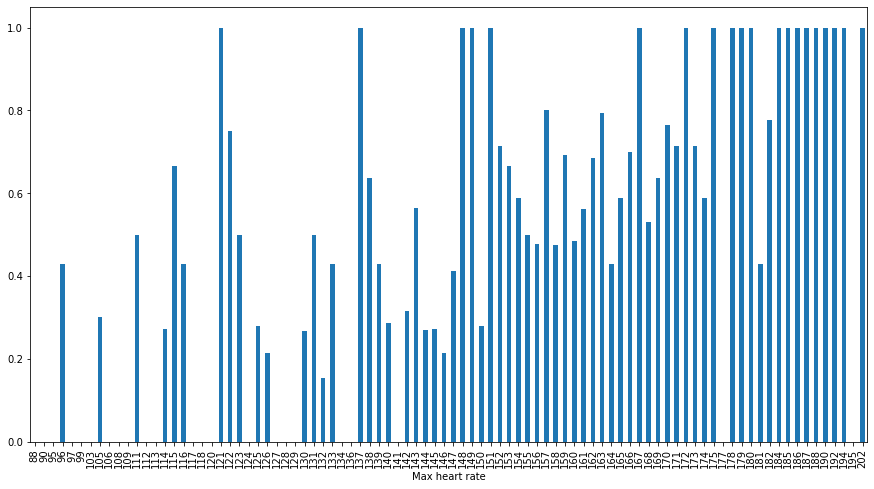

In [33]:
maxHR["target"].plot.bar(xlabel="Max heart rate", figsize=(15,8))

Based on this chart there seems to be a general increase increase in heart disease entries the higher the max heart rate is. So this seems to indicate that the higher your maximum heart rate can go, the more likely you are to have heart disease.

#### oldpeak - ST depression induced by exercise relative to rest
With correlation coefficient -0.4384

In [34]:
st = df.groupby('oldpeak').mean()
st.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,target
oldpeak,,,,,,,,,,,,,
0.0,50.753799,0.662614,1.079027,128.911854,240.431611,0.121581,0.562310,162.188450,0.185410,1.832827,0.550152,2.136778,0.735562
0.1,55.869565,0.869565,0.652174,121.391304,222.869565,0.391304,0.434783,145.695652,0.304348,1.608696,1.391304,2.434783,0.521739
0.2,56.567568,0.513514,1.216216,135.378378,254.918919,0.162162,0.648649,149.027027,0.324324,1.405405,0.405405,2.513514,0.729730
0.3,56.100000,0.400000,1.000000,116.800000,243.900000,0.000000,1.000000,143.700000,0.000000,1.700000,0.900000,2.400000,0.600000
0.4,58.133333,0.800000,0.966667,129.733333,241.266667,0.000000,0.533333,151.100000,0.100000,1.300000,0.866667,2.400000,0.866667


<AxesSubplot:xlabel='ST depression induced by exercise relative to rest'>

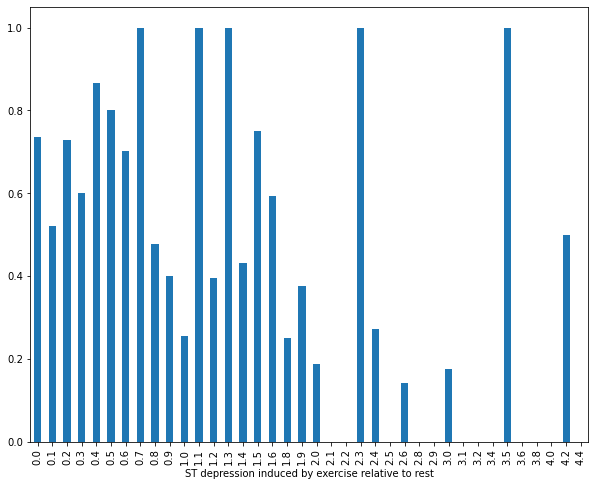

In [35]:
st["target"].plot.bar(xlabel="ST depression induced by exercise relative to rest", figsize=(10,8))

On this graph we see a drop in cases with heart disease the higher the value of ST depression. This seems to indicate that people with higher levels of ST depression have a lower chance of having a heart disease.

#### Dimensionality reduction

Now we believe it would be smart to standarize our data, because we have wide spread data values.

In [36]:
from sklearn.preprocessing import StandardScaler
features = df.columns
array = df.values
# Separating out the features
X = array[:, 0:13]
# Separating out the target
y = array[:,13]
# Standardizing the features
X = StandardScaler().fit_transform(X)

With this we should have prepared this dataset for machine learning and the modeling we will proceed with.

## Training a model

To train models on our data we want to split it into a training set and a test set. Since we are performing supervised learning we do this for all X-columns and the y-column.

In [37]:
# We use 80% of the data for training and the remaining 20% for testing
test_set_size = 0.2

# Initial value for randomization
seed = 42
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_set_size, random_state=seed)

Our training data is X_train and y_train with the validation data being X_test and y_test. Now we can train a model using some algoritms. First off let's try the Gaussian Naive Bayes.

In [38]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [39]:
# Test on the test data, try prediction
prediction = model.predict(X_test)
prediction

array([1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.])

In [40]:
# Calculated accuracy of the model over the validation set
print(accuracy_score(y_test, prediction))

0.8325123152709359


In [41]:
# Confusion matrix to give an idea about the errors
print(confusion_matrix(y_test, prediction))

[[80 25]
 [ 9 89]]


In [42]:
# Classification report provides a breakdown of each class by precision, recall, f1-score and support
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82       105
         1.0       0.78      0.91      0.84        98

    accuracy                           0.83       203
   macro avg       0.84      0.84      0.83       203
weighted avg       0.84      0.83      0.83       203



Our model predicts the outcomes on the test set with a 83% accuracy, which isn't bad. Let's try predict the output with completely new data.

In [43]:
# perhaps get row from data that isn't trained on
test = [[35, 0, 2, 130, 170, 1, 0, 150, 1, 2.0, 2, 0, 2]]
new_prediction = model.predict(test)
new_prediction

array([0.])

This data we fabricated seem to result in the target value 0, which mean a person without heart disease. Let's try out some other models using cross validation.

In [44]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('NB', GaussianNB()))

In [45]:
# We run all the algorithms on our data and store their results in results[] and names in names[]
results = []
names = []
for name, model in models:
    # We split the data into 10 folds at random
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    
    # We use the model with the cross validation folds and get the score
    cv_results = model_selection.cross_val_score(model, X_test, y_test, cv=kfold, scoring="accuracy")
    
    # We save the score
    results.append(cv_results)
    
    # We save the model name
    names.append(name)
    
    # Here we then print the results
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)   


LR: 0.818333 (0.089075)
KNN: 0.813810 (0.094670)
CART: 0.808571 (0.100182)
RFC: 0.862857 (0.075834)
NB: 0.798333 (0.090156)


This approach has certainly saved a lot of time. We can see the results of each model above, and it would seem that the RandomForestClassifier performs the best on our data. Let's see if we can plot these performances in a graph.

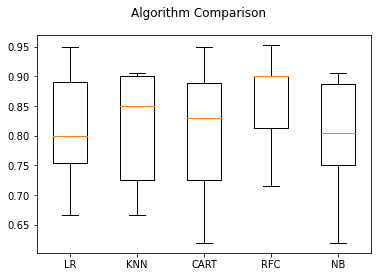

In [46]:
# We want to plot the performance of each algorithm
fig = plt.figure()
fig.suptitle('Algorithm Comparison')

# x axis includes sub-plots
ax = fig.add_subplot(111)

# y axis result values
plt.boxplot(results)

# x axis labels
ax.set_xticklabels(names)

plt.show()

Based on these tests and the best performing algorithm is the RandomForestClassifier. Let's try to use it

In [47]:
model = RandomForestClassifier();
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# Calculated accuracy of the model over the validation set
print("Accuracy score:", accuracy_score(y_test, predictions))

# Confusion matrix provides an indication of the three errors made ???? errors of predictions?
print(confusion_matrix(y_test, predictions))
    
# Classification report provides a breakdown of each class by precision, recall, f1-score and support ????
print(classification_report(y_test, predictions))

Accuracy score: 1.0
[[105   0]
 [  0  98]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       105
         1.0       1.00      1.00      1.00        98

    accuracy                           1.00       203
   macro avg       1.00      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203



This random forest classifier seems to have an accuracy score of 100% and the confusion matrix also has 105 true negatives, 98 true positives, 0 false positives and 0 false negatives. This might be because our data has many highly correlated fields to the target. Let's try to calculate precision and recall.

In [48]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_test, predictions))
print(recall_score(y_test, predictions))

1.0
1.0


The precision and recall also seem to be the highest it can be, which is suspicious. Let's try to calculate the f1 score.

In [49]:
from sklearn.metrics import f1_score

f1_score(y_test, predictions)

1.0

So our model seem to be a "perfect" predicter on our data. This might be a result of this dataset possibly being biased, and the columns might have been specifically selected by experts because they might have insight into how much they impact heart disease prediction. We tried deviding the test set into a third of the data, but it gave the same result. I will continue for now with this model, because it seems to be good regardless.

We now have a model that we can use for prediction. To be able to use this model however we want to export it so it can be imported in other projects.

In [50]:
import joblib
joblib.dump(model, 'deploy/data1_model.pkl')

['deploy/data1_model.pkl']

In [51]:
# deleteme
#visual =df.copy()
#bins = [20, 30, 40, 50, 60, 70, 80]
#visual["age"] = pd.cut(visual.age, bins)
# Test til at se hvilken visualization der passer bedst
#age = visual.groupby("age").mean()
#age_chart = age["target"].plot(kind="area", figsize=(15, 8))
#fig = age_chart.get_figure()
#fig.savefig('static/ageChartDS1.png')

In [52]:
#age_pie = age["target"].plot(kind="pie", figsize=(15, 8), ylabel="", title="Age groups and heart disease", legend=[""])
#fig = age_pie.get_figure()
#fig.savefig('static/agePieDS1.png')

In [53]:
#cp = visual.groupby('cp').mean()

#cp['target'].plot.pie(title="Heart disease patients with chest pain types 0-3", ylabel="", legend=[""])

In [54]:
#df.plot.scatter(x='target', y='age', figsize=(6, 6), marker = '$\u25EF$')

In [55]:
#sns.violinplot(df.target, df.age, inner="quartile", color="yellow")

In [56]:
#visual2 = df.copy()
#bins2 = [90, 110, 130, 150, 170, 190, 210]
#visual2["thalach"] = pd.cut(visual2.thalach, bins2)
#hr = visual2.groupby('thalach').mean()
#hr_chart = hr["target"].plot.bar(xlabel="Max heart rate", ylabel="Heart disease", figsize=(15,8))
#fig = hr_chart.get_figure()
#fig.savefig('static/hrChart.png')

In [58]:
outliers = df[df['chol'] > 371.0] # removed some possible outliers to make visualization possible with website "venngage"
df = df.drop(outliers.index.values)
df.shape

(998, 14)

In [73]:
df.to_csv('datasets/data1_visualization.csv', index=True)

In [61]:
visual =df.copy()
bins = [20, 30, 40, 50, 60, 70, 80]
visual["age"] = pd.cut(visual.age, bins)
# Test til at se hvilken visualization der passer bedst
age = visual.groupby("age").mean()
age.to_csv('datasets/data1_age_target.csv', index=True)

In [63]:
visual2 = df.copy()
bins2 = [90, 110, 130, 150, 170, 190, 210]
visual2["thalach"] = pd.cut(visual2.thalach, bins2)
hr = visual2.groupby('thalach').mean()
hr.to_csv('datasets/data1_hr_target.csv', index=True)

In [76]:
visual =df.copy()
#bins = [20, 30, 40, 50, 60, 70, 80]
#visual["age"] = pd.cut(visual.age, bins)
# Test til at se hvilken visualization der passer bedst
sex = visual.groupby("sex").mean()
sex.to_csv('datasets/data1_sex.csv', index=True)